## Mini Proc Model with MiniAE to demonstrate the use of LTN in an Autoencoder
1. Generate the data
2. Train the Autoencoder
3. Modify the AE with LTN

## Mini Proc Model
### Process

e1 -> e2 -> e3 -> e4 -> e5

event attributes = name, user

event_names = ["Create SC", "Approve SC", "Create PO", "Approve PO", "Pay"]

user_names = ["Dev", "Chantal", "Seokju", "Jonas", "Kaly"]

### Valid traces
1. ["Create SC", "Approve SC", "Create PO", "Approve PO", "Pay"]
2. ~~["Create SC", "Create PO", "Approve SC", "Approve PO", "Pay"]~~ for now

### Event User Mapping
1. "Create SC" : "Dev", "Chantal" 
2. "Approve SC" : "Kaly"
3. "Create PO" : "Dev", "Jonas"
4. "Approve PO" : "Kaly"
5. "Pay" : "Seokju"

### Data
1. Traces = 1000
2. p_anomaly = 0.3 # This means that the possibility that a given trace is anomalous is 0.3
3. Anomaly types:
    1. Control flow: irregular flow ordering
    2. Attribute: Wrong attributes assigned

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from pprint import pprint
import may
import itertools
import pickle

np.random.seed(0)

In [3]:
import tensorflow as tf
from tensorflow import keras
import ltn
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU found")
    print("Memory growth set")
else:
    print("No GPU found")
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise, Reshape, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from typing import Union
import ltn

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU found
Memory growth set


In [4]:
synth_dataset = may.Dataset(max_cases=5000, anomaly_probabilty=0.3)
synth_dataset.create_dataset()
print(f"Cases Distribution: {synth_dataset.actual_cases}")
one_hot_flat = synth_dataset.one_hot_encoded_features
print(f"one_hot_flat shape: {one_hot_flat.shape}")
print(f"Raw features test:\n{synth_dataset.raw_dataset_as_df[:5]}")
print(f"Encoded Features test:\n{synth_dataset.encoded_features[0]}")
# pprint(f"One hot Encoded feature test: {one_hot_flat[0]}")
print(f"De encoding test:\n{synth_dataset.inverse_one_hot_encoded_features_to_int(one_hot_flat[0])}")
# from pprint import pprint
# pprint(f"Encoded Features: {temp.shape}")
# temp = synth_dataset.one_hot_encoded_features
# pprint(f"One hot Encoded Features: {temp.shape}")
# int_de_encode = synth_dataset.inverse_one_hot_encoded_features_to_int(temp[0])
# print(f"De encoding test: {int_de_encode}")
# str_de_encode = synth_dataset.inverse_one_hot_encoded_features_to_string(temp[0])

encoders[name]:
[('Approve PO', '0'), ('Approve SC', '1'), ('Create PO', '2'), ('Create SC', '3'), ('Pay', '4')]
encoders[user]:
[('Chantal', '0'), ('Dev', '1'), ('Jonas', '2'), ('Kaly', '3'), ('Seokju', '4')]
Cases Distribution: [3500, 748, 750]
one_hot_flat shape: (4998, 50)
Raw features test:
         name    user  case_id
0   Create SC     Dev        0
1  Approve SC    Kaly        0
2   Create PO   Jonas        0
3  Approve PO    Kaly        0
4         Pay  Seokju        0
Encoded Features test:
[3 1 1 3 2 2 0 3 4 4]
De encoding test:
[[3 1 1 3 2 2 0 3 4 4]]


In [5]:
class BIGDAE():
    """
    A class container to hold the DAE model outputs with a shared latent space
    The Class contains each output as a separate model and a shared latent space model
    Each output is later converted to a LTN Predicate
    """
    def __init__(self, dataset: may.Dataset, hidden_layers:int=2, hidden_size_factor:Union[float, list]=0.2, noise:bool=True):
        self.dataset = dataset
        self.model = None # Main model which will be trained on one hot encoded features of dataset
        self.input_layer = None # keras input layer of the model
        self.latent_space_last_layer = None # shared latent space/decoder layer of the models 
        self.individual_outputs = [] # individual outputs of the model
        self.output_layer = [] # Single output of the model 
        self.individual_models = [] # models for each output, which have shared input and latent spcae layers
        self.ltn_predicates = [] # LTN predicates for each output
        self.history = None # training history of the model
        
        # Parameters
        self.hidden_layers = hidden_layers # 2
        self.hidden_size_factor = hidden_size_factor # 0.2
        self.noise = noise # for denoising autoencoder
        self.input_shape = self.dataset.one_hot_encoded_features_2d.shape[1:]
        # print(f"self.input_shape: {self.input_shape}")        
        pass
    
    def _build_main_model(self):
        
        # Layers
        self.input_layer = Input(shape=(*self.input_shape, ), name='input')
        self.flat_input = Flatten(name="flatten")(self.input_layer)
        
        # Noise layer
        if self.noise is not None:
            x = GaussianNoise(self.noise, name="noise")(self.flat_input)

        # Hidden layers
        for i in range(self.hidden_layers):
            if isinstance(self.hidden_size_factor, list):
                factor = self.hidden_size_factor[i]
            else:
                factor = self.hidden_size_factor
            x = Dense(int(self.input_shape[0] * self.input_shape[1] * factor), activation='elu', name=f'hidden-{i}')(x)
            x = Dropout(0.5, name=f'dropout-{i}')(x)

        # latent space
        self.latent_space_last_layer = x

        # Output layer(s)
        self.individual_outputs = []
        for i in range(self.input_shape[0]):
            name = f"event-{i//2}" if i%2==0 else f"user-{i//2}"
            output = Dense(self.input_shape[1], activation='sigmoid', name=name)(self.latent_space_last_layer)
            self.individual_outputs.append(output)

        self.output_layer = Concatenate(axis=1, name="concatenate")(self.individual_outputs)
        self.output_layer = Reshape((self.input_shape[0], self.input_shape[1]), name="output-layer-reshape")(self.output_layer)
        
        # Build model
        self.model = Model(inputs=self.input_layer, outputs=self.output_layer, name="main-DAE")
        # self.model._name = "Main DAE"
        pass
    
    def _compile_main_model(self):
        # Compile model
        self.model.compile(
            optimizer=Adam(learning_rate=0.0001, beta_2=0.99),
            loss='mean_squared_error',
            metrics=['accuracy']
        )
        pass
    
    def _build_individual_models(self):
        # Build individual models
        self.individual_models = []
        for individual_output in self.individual_outputs:
            name = f"individual-{individual_output.name}".split(r"/")[0]
            individual_model = Model(inputs=self.input_layer, outputs=individual_output, name=name)
            # individual_model._name = f"Individual {individual_output.name}"
            self.individual_models.append(individual_model)
        pass
    
    
    def _compile_individual_models(self):
        # Compile individual models
        for individual_model in self.individual_models:
            individual_model.compile(
                optimizer=Adam(learning_rate=0.00001, beta_2=0.99),
                loss='mean_squared_error',
            )
        pass
    
    def build(self):
        self._build_main_model()
        self._compile_main_model()
        self._build_individual_models()
        self._compile_individual_models()
        pass
    
    def fit(self, epochs:int=150, batch_size:int=500, validation_split:float=0.2, verbose:int=1):
        self.history = self.model.fit(
            self.dataset.one_hot_encoded_features_2d, self.dataset.one_hot_encoded_features_2d,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=validation_split,
            verbose=verbose,
        )
        pd.DataFrame(self.history.history).plot(figsize=(8,5))
        plt.show()
    
    def predict(self, test_vector):
        return self.model.predict(test_vector)
    
    def _summary_main_model(self):
        print("Printing Main Model Summary")
        self.model.summary()
        pass
    
    def _summary_individual_models(self):
        print("Printing Individual Models Summary")
        for individual_model in self.individual_models:
            individual_model.summary()
        pass
    
    def save_pickle(self):
        with open("daemodel.pkl", "wb") as fp:
            pickle.dump(self, fp, protocol=-1)
    
    def summary(self):
        self._summary_main_model()
        self._summary_individual_models()
        pass
        
        

In [6]:
main_model = BIGDAE(synth_dataset)
main_model.build()

Epoch 1/150
8/8 [==============================] - 3s 41ms/step - loss: 0.3257 - accuracy: 0.2060 - val_loss: 0.2591 - val_accuracy: 0.2324
Epoch 2/150
8/8 [==============================] - 0s 12ms/step - loss: 0.3254 - accuracy: 0.2048 - val_loss: 0.2586 - val_accuracy: 0.2348
Epoch 3/150
8/8 [==============================] - 0s 11ms/step - loss: 0.3231 - accuracy: 0.2059 - val_loss: 0.2580 - val_accuracy: 0.2367
Epoch 4/150
8/8 [==============================] - 0s 10ms/step - loss: 0.3220 - accuracy: 0.2025 - val_loss: 0.2575 - val_accuracy: 0.2402
Epoch 5/150
8/8 [==============================] - 0s 11ms/step - loss: 0.3214 - accuracy: 0.2037 - val_loss: 0.2571 - val_accuracy: 0.2407
Epoch 6/150
8/8 [==============================] - 0s 10ms/step - loss: 0.3189 - accuracy: 0.2115 - val_loss: 0.2566 - val_accuracy: 0.2409
Epoch 7/150
8/8 [==============================] - 0s 11ms/step - loss: 0.3202 - accuracy: 0.2101 - val_loss: 0.2562 - val_accuracy: 0.2415
Epoch 8/150
8/8 [===

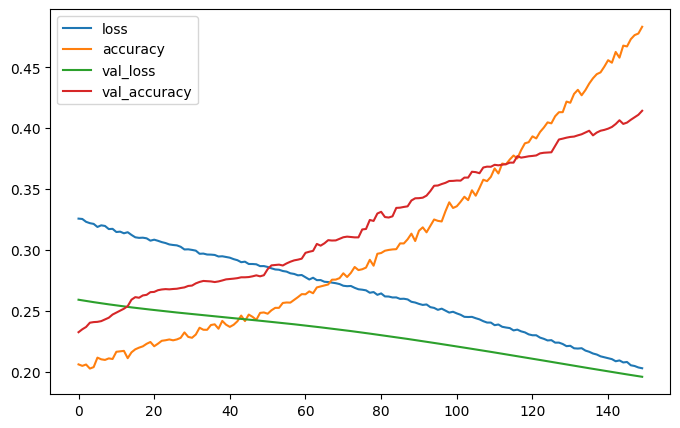

In [7]:
main_model.fit()

In [8]:
# main_model.save_pickle()

In [9]:
test_vector_2d = synth_dataset.one_hot_encoded_features_2d[4000].reshape(-1, 10, 5)
pprint(test_vector_2d)
op = main_model.predict(test_vector_2d)
pprint(op)

array([[[0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.]]])
1/1 [==============================] - 0s 113ms/step
array([[[0.399535  , 0.3635315 , 0.44766787, 0.539357  , 0.2983339 ],
        [0.3973788 , 0.52563375, 0.24199551, 0.44605416, 0.36175808],
        [0.21407554, 0.6436223 , 0.49677145, 0.32439372, 0.67969525],
        [0.39568263, 0.25346726, 0.29841805, 0.6998303 , 0.50677156],
        [0.5169117 , 0.23341048, 0.74228436, 0.3304551 , 0.21865971],
        [0.36612663, 0.48537746, 0.5300082 , 0.36965418, 0.3258718 ],
        [0.62620866, 0.39741024, 0.42092916, 0.40036842, 0.36511138],
        [0.42735875, 0.35756195, 0.55777454, 0.73871994, 0.2297211 ],
        [0.35955215, 0.3239657 , 0.19654554, 0.23343855, 0.73516524],
        [0.3139

In [10]:
first_event_prediction = main_model.individual_models[0].predict(test_vector_2d)
pprint(first_event_prediction)

1/1 [==============================] - 0s 47ms/step
array([[0.399535  , 0.3635315 , 0.44766787, 0.539357  , 0.2983339 ]],
      dtype=float32)


In [11]:
x_one_hot_2d, y_int = synth_dataset.x_one_hot_2d_y_int
x_one_hot_2d = x_one_hot_2d.reshape(-1, 10, 5)
print(x_one_hot_2d.shape, y_int.shape)
print(x_one_hot_2d[0], y_int[0], sep="\n")
y_int_first_event = y_int[:, 0]
print(y_int_first_event.shape)
print(y_int_first_event[:5])
# x_one_hot_2d_first_event = x_one_hot_2d[:, 0]
# print(x_one_hot_2d_first_event.shape)
# print(x_one_hot_2d_first_event[0])

(4998, 10, 5) (4998, 10)
[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
[3 1 1 3 2 2 0 3 4 4]
(4998,)
[3 3 3 3 3]


In [12]:
permuted_indices = np.random.permutation(one_hot_flat.shape[0])
x_one_hot_2d = x_one_hot_2d[permuted_indices]
y_int = y_int[permuted_indices]
split_point = int(one_hot_flat.shape[0] * 0.8 )
x_one_hot_2d_train = x_one_hot_2d[:split_point]
x_one_hot_2d_test = x_one_hot_2d[split_point:]
y_int_train = y_int[:split_point]
y_int_test = y_int[split_point:]

print(f"x_one_hot_2d_train.shape: {x_one_hot_2d_train.shape}")
print(f"x_one_hot_2d_test.shape: {x_one_hot_2d_test.shape}")
print(f"y_int_train.shape: {y_int_train.shape}")
print(f"y_int_test.shape: {y_int_test.shape}")

x_one_hot_2d_train.shape: (3998, 10, 5)
x_one_hot_2d_test.shape: (1000, 10, 5)
y_int_train.shape: (3998, 10)
y_int_test.shape: (1000, 10)


In [13]:
x_one_hot_2d_train[0]

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [14]:
batch_size = 500
ds_train = tf.data.Dataset.from_tensor_slices((x_one_hot_2d_train,y_int_train)).batch(batch_size)
ds_test = tf.data.Dataset.from_tensor_slices((x_one_hot_2d_test,y_int_test)).batch(batch_size)

In [15]:
tf.print(ds_train)

<BatchDataset element_spec=(TensorSpec(shape=(None, 10, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 10), dtype=tf.int32, name=None))>


In [16]:
for features, labels in ds_test:
    tf.print(features[0])
    tf.print(main_model.individual_models[0].predict(features)[0])
print(main_model.individual_models[0].predict(tf.reshape(x_one_hot_2d_test, [-1,  10, 5]))[0])

[[0 0 0 1 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 ...
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 1]]
16/16 [==============================] - 0s 1ms/step
array([0.33639845, 0.29393628, 0.414225  , 0.5201815 , 0.22888021],
      dtype=float32)
[[0 0 0 1 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 ...
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]]
16/16 [==============================] - 0s 1ms/step
array([0.3852544 , 0.30112618, 0.48274145, 0.43908232, 0.24397199],
      dtype=float32)
32/32 [==============================] - 0s 1ms/step
[0.33639845 0.29393628 0.414225   0.5201815  0.22888021]


In [17]:
main_model.individual_models[0].predict(x_one_hot_2d_train)

125/125 [==============================] - 0s 971us/step


array([[0.35427353, 0.29661617, 0.45433563, 0.49358526, 0.24348417],
       [0.33639845, 0.29393628, 0.414225  , 0.5201815 , 0.22888021],
       [0.33639845, 0.29393628, 0.414225  , 0.5201815 , 0.22888021],
       ...,
       [0.33639845, 0.29393628, 0.414225  , 0.5201815 , 0.22888021],
       [0.33639845, 0.29393628, 0.414225  , 0.5201815 , 0.22888021],
       [0.35041657, 0.29512706, 0.42791563, 0.5324375 , 0.26176494]],
      dtype=float32)

## Defining LTN Predicates

### Encodings

encoders[name]:

[('Approve PO', '0'), ('Approve SC', '1'), ('Create PO', '2'), ('Create SC', '3'), ('Pay', '4')]

encoders[user]:

[('Chantal', '0'), ('Dev', '1'), ('Jonas', '2'), ('Kaly', '3'), ('Seokju', '4')]


In [20]:
first_event_predicate = ltn.Predicate.FromLogits(main_model.individual_models[0], activation_function="softmax", with_class_indexing=True)
first_user_predicate = ltn.Predicate.FromLogits(main_model.individual_models[1], activation_function="softmax", with_class_indexing=True)
event_predicates = []
user_predicates = []
for i in range(0, 10, 2):
    event_predicates.append(ltn.Predicate.FromLogits(main_model.individual_models[i], activation_function="softmax", with_class_indexing=True))
for i in range(1, 10, 2):
    user_predicates.append(ltn.Predicate.FromLogits(main_model.individual_models[i], activation_function="softmax", with_class_indexing=True))
    
# order taken from the label encoder 
event_approve_po = ltn.Constant(0, trainable=False)
event_approve_sc = ltn.Constant(1, trainable=False)
event_create_po = ltn.Constant(2, trainable=False)
event_create_sc = ltn.Constant(3, trainable=False)
event_pay = ltn.Constant(4, trainable=False)

user_chantal = ltn.Constant(0, trainable=False)
user_dev = ltn.Constant(1, trainable=False)
user_jonas = ltn.Constant(2, trainable=False)
user_kaly = ltn.Constant(3, trainable=False)
user_seokju = ltn.Constant(4, trainable=False)

In [22]:
x_var = ltn.Variable("x_var", x_one_hot_2d_train[0].reshape(-1, 10, 5))
y_var = ltn.Variable("y_var", y_int_train[0, 0].reshape(-1, 1))
first_event_predicate([x_var, y_var])

ltn.Formula(tensor=[[0.22566204]], free_vars=['x_var', 'y_var'])

In [21]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")


In [23]:
for j in range(2):
    for i in range(5):
        print(j, i, x_one_hot_2d[y_int[:, j]==i].shape)

0 0 (0, 10, 5)
0 1 (187, 10, 5)
0 2 (187, 10, 5)
0 3 (4624, 10, 5)
0 4 (0, 10, 5)
1 0 (1958, 10, 5)
1 1 (2005, 10, 5)
1 2 (358, 10, 5)
1 3 (430, 10, 5)
1 4 (247, 10, 5)


In [24]:
print(y_int_train[0, 0])
x_var = ltn.Variable("x_var", x_one_hot_2d_train[:5].reshape(-1, 10, 5))
# y_var = ltn.Variable("y_var",  event_create_sc)
print("predict ind model")
print(main_model.individual_models[0].predict(x_one_hot_2d_train[:5].reshape(-1, 10, 5)))
sigmoid_op = tf.math.softmax(main_model.individual_models[0].predict(x_one_hot_2d_train[:5].reshape(-1, 10, 5)))
print("print sigmoid")
print(sigmoid_op)
first_event_predicate([x_var, event_create_sc]) 
first_user_predicate([x_var, event_create_sc])

3
predict ind model
1/1 [==============================] - 0s 19ms/step
[[0.35427353 0.29661617 0.45433563 0.49358526 0.24348417]
 [0.33639845 0.29393628 0.414225   0.5201815  0.22888021]
 [0.33639845 0.29393628 0.414225   0.5201815  0.22888021]
 [0.36865938 0.38071012 0.47222528 0.52162707 0.29609042]
 [0.35041657 0.29512706 0.42791563 0.5324375  0.26176494]]
1/1 [==============================] - 0s 18ms/step
print sigmoid
tf.Tensor(
[[0.19631623 0.1853173  0.21697646 0.22566204 0.17572802]
 [0.19458368 0.1864942  0.21033235 0.23384194 0.17474787]
 [0.19458368 0.1864942  0.21033235 0.23384194 0.17474787]
 [0.19169827 0.19402234 0.21261615 0.22338355 0.17827968]
 [0.19449212 0.18403064 0.21016455 0.23332042 0.17799225]], shape=(5, 5), dtype=float32)


ltn.Formula(tensor=[0.21328004 0.21243085 0.21243085 0.20798182 0.20740584], free_vars=['x_var'])

In [98]:
# test_x_first_event_approve_sc = ltn.Variable("x_event_approve_sc",features[labels[:, 0]==1])
# Forall(test_x_first_event_approve_sc, Not(first_event_predicate([test_x_first_event_approve_sc, event_approve_sc]))), # Not
import ltn
x_first_event_approve_po = ltn.Variable("x_event_approve_po",features[labels[:, 0]==0])
x_first_event_approve_sc = ltn.Variable("x_event_approve_sc",features[labels[:, 0]==1])
x_first_event_create_po = ltn.Variable("x_event_create_po",features[labels[:, 0]==2])
x_first_event_create_sc = ltn.Variable("x_event_create_sc",features[labels[:, 0]==3])
x_first_event_pay = ltn.Variable("x_event_pay",features[labels[:, 0]==4])

ax = [
    Forall(x_first_event_approve_sc, Not(first_event_predicate([x_first_event_approve_sc, event_approve_sc]))),
    Forall(x_first_event_create_po, Not(first_event_predicate([x_first_event_create_po, event_create_po]))),
    Forall(x_first_event_create_sc, first_event_predicate([x_first_event_create_sc, event_create_sc]))
]

formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=2))
print("Formag")
print(formula_aggregator(ax))


Formag
ltn.Formula(tensor=0.5549899935722351, free_vars=[])


### Valid traces
1. ["Create SC", "Approve SC", "Create PO", "Approve PO", "Pay"]
2. ~~["Create SC", "Create PO", "Approve SC", "Approve PO", "Pay"]~~ for now

### Event User Mapping
1. "Create SC" : "Dev", "Chantal" 
2. "Approve SC" : "Kaly"
3. "Create PO" : "Dev", "Jonas"
4. "Approve PO" : "Kaly"
5. "Pay" : "Seokju"

In [28]:
formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=2))

# x_one_hot_2d, y_int[:, 0]
@tf.function
def axioms(features, labels, training=False):
    traces = ltn.Variable("traces",features)
    
    axioms = [
        Forall(traces, event_predicates[0]([traces, event_create_sc], training=training)),
        Forall(traces, user_predicates[0]([traces, user_dev], training=training)),
        Forall(traces, user_predicates[0]([traces, user_chantal], training=training)),
        
        Forall(traces, event_predicates[1]([traces, event_approve_sc], training=training)),
        Forall(traces, user_predicates[1]([traces, user_kaly], training=training)),
        
        Forall(traces, event_predicates[2]([traces, event_create_po], training=training)),
        Forall(traces, user_predicates[2]([traces, user_dev], training=training)),
        Forall(traces, user_predicates[2]([traces, user_jonas], training=training)),
        
        Forall(traces, event_predicates[3]([traces, event_approve_po], training=training)),
        Forall(traces, user_predicates[3]([traces, user_kaly], training=training)),
        
        Forall(traces, event_predicates[4]([traces, event_pay], training=training)),
        Forall(traces, user_predicates[4]([traces, user_seokju], training=training))
        
        # TODO: Write the exclusion axioms
    ]
    sat_level = formula_aggregator(axioms).tensor
    return sat_level

In [29]:
# formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=2))

# # x_one_hot_2d, y_int[:, 0]
# @tf.function
# def axioms(features, labels, training=False):
#     x_first_event_approve_po = ltn.Variable("x_event_approve_po",features[labels[:, 0]==0])
#     x_first_event_approve_sc = ltn.Variable("x_event_approve_sc",features[labels[:, 0]==1])
#     x_first_event_create_po = ltn.Variable("x_event_create_po",features[labels[:, 0]==2])
#     x_first_event_create_sc = ltn.Variable("x_event_create_sc",features[labels[:, 0]==3])
#     x_first_event_pay = ltn.Variable("x_event_pay",features[labels[:, 0]==4])
#     x_first_user_chantal = ltn.Variable("x_user_chantal",features[labels[:, 1]==0])
#     x_first_user_dev = ltn.Variable("x_user_dev",features[labels[:, 1]==1])
#     x_first_user_jonas = ltn.Variable("x_user_jonas",features[labels[:, 1]==2])
#     x_first_user_kaly = ltn.Variable("x_user_kaly",features[labels[:, 1]==3])
#     x_first_user_seokju = ltn.Variable("x_user_seokju",features[labels[:, 1]==4])
#     # print(x_first_user_seokju)
    
#     axioms = [
#         # Forall(x_first_event_approve_po, Not(first_event_predicate([x_first_event_approve_po, event_approve_po]))), # There are no examples of this so switch off
#         Forall(x_first_event_approve_sc, Not(first_event_predicate([x_first_event_approve_sc, event_approve_sc], training=training))), # Not
#         Forall(x_first_event_create_po, Not(first_event_predicate([x_first_event_create_po, event_create_po], training=training))), # Not
#         Forall(x_first_event_create_sc, first_event_predicate([x_first_event_create_sc, event_create_sc], training=training)), # True
#         # Forall(x_first_event_pay, Not(first_event_predicate([x_first_event_pay, event_pay]))), # There are no examples of this so switch off
#         Forall(x_first_user_chantal, first_user_predicate([x_first_user_chantal, user_chantal], training=training)), # True
#         Forall(x_first_user_dev, first_user_predicate([x_first_user_dev, user_dev], training=training)), # True
#         Forall(x_first_user_jonas, Not(first_user_predicate([x_first_user_jonas, user_jonas], training=training))),
#         Forall(x_first_user_kaly, Not(first_user_predicate([x_first_user_kaly, user_kaly], training=training))),
#         Forall(x_first_user_seokju, Not(first_user_predicate([x_first_user_seokju, user_seokju], training=training)))
#     ]
#     sat_level = formula_aggregator(axioms).tensor
#     return sat_level

In [30]:
for features, labels in ds_test:
    # print(features.shape, labels[:, 0].shape)
    print("Initial sat level %.5f"%axioms(features,labels))
    

Initial sat level 0.25077
Initial sat level 0.25021


In [31]:
metrics_dict = {
    'train_sat_kb': tf.keras.metrics.Mean(name='train_sat_kb'),
    'test_sat_kb': tf.keras.metrics.Mean(name='test_sat_kb')
#     'train_accuracy': tf.keras.metrics.CategoricalAccuracy(name="train_accuracy"),
#     'test_accuracy': tf.keras.metrics.CategoricalAccuracy(name="test_accuracy")
}

In [35]:
print(event_predicates[0].trainable_variables)
trainable_variables_events = [event_predicate.trainable_variables for event_predicate in event_predicates]
print(len(trainable_variables_events))
trainable_variables_events = list(itertools.chain.from_iterable(trainable_variables_events))
print(len(trainable_variables_events))


[<tf.Variable 'hidden-0/kernel:0' shape=(50, 10) dtype=float32, numpy=
array([[-1.52028268e-02, -5.11185266e-02, -1.14530483e-02,
        -2.15376064e-01, -1.09223723e-01,  8.68767276e-02,
         1.28555000e-01,  9.11926851e-02,  4.63392995e-02,
        -2.73253825e-02],
       [-7.52508044e-02,  1.12862125e-01,  1.12740152e-01,
        -1.19114302e-01,  6.33203611e-02, -1.15870394e-01,
         2.70587876e-02,  6.02644905e-02,  1.66292861e-01,
        -1.03592448e-01],
       [ 2.19760522e-01,  2.22997427e-01, -1.98909506e-01,
        -2.21954554e-01,  1.45575143e-02,  1.34845212e-01,
        -5.27546443e-02,  1.29665196e-01, -7.55051225e-02,
         1.66834518e-01],
       [-2.54281670e-01, -3.86591494e-01,  1.11380622e-01,
         2.05079257e-01,  3.09418365e-02,  2.03910157e-01,
        -4.12570000e-01, -1.14961177e-01,  1.61314309e-01,
        -1.87790051e-01],
       [ 2.15914249e-01, -1.13707902e-02,  5.60034662e-02,
        -1.00834332e-01, -1.06056146e-01, -9.77774411e-02,

In [36]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_2=0.99)
@tf.function
def train_step(features, labels):
    # sat and update
    trainable_variables_events = [event_predicate.trainable_variables for event_predicate in event_predicates]
    trainable_variables_events = list(itertools.chain.from_iterable(trainable_variables_events))
    trainable_variables_users = [user_predicate.trainable_variables for user_predicate in user_predicates]
    trainable_variables_users = list(itertools.chain.from_iterable(trainable_variables_users))
    trainable_variables = trainable_variables_events + trainable_variables_users
    with tf.GradientTape() as tape:
        sat = axioms(features, labels, training=True)
        loss = 1.-sat
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    sat = axioms(features, labels) # compute sat without dropout
    metrics_dict['train_sat_kb'](sat)
    # accuracy
    # predictions = main_model.individual_models[0](features)
    # tf.print(predictions[0])
    # metrics_dict['train_accuracy'](tf.one_hot(labels,3),predictions)
    
@tf.function
def test_step(features, labels):
    # sat
    sat = axioms(features, labels)
    metrics_dict['test_sat_kb'](sat)
    # accuracy
    # predictions = logits_model([features])
    # metrics_dict['test_accuracy'](tf.one_hot(labels,3),predictions)

In [37]:
from collections import defaultdict

def train(
        epochs,
        metrics_dict, 
        ds_train, 
        ds_test, 
        train_step, 
        test_step,
        track_metrics=1,
        csv_path=None,
        scheduled_parameters=defaultdict(lambda : {})
    ):
    """
    Args:
        epochs: int, number of training epochs.
        metrics_dict: dict, {"metrics_label": tf.keras.metrics instance}.
        ds_train: iterable dataset, e.g. using tf.data.Dataset.
        ds_test: iterable dataset, e.g. using tf.data.Dataset.
        train_step: callable function. the arguments passed to the function
            are the itered elements of ds_train.
        test_step: callable function. the arguments passed to the function
            are the itered elements of ds_test.
        csv_path: (optional) path to create a csv file, to save the metrics.
        scheduled_parameters: (optional) a dictionary that returns kwargs for
            the train_step and test_step functions, for each epoch.
            Call using scheduled_parameters[epoch].
    """
    template = "Epoch {}"
    for metrics_label in metrics_dict.keys():
        template += ", %s: {:.4f}" % metrics_label
    if csv_path is not None:
        csv_file = open(csv_path,"w+")
        headers = ",".join(["Epoch"]+list(metrics_dict.keys()))
        csv_template = ",".join(["{}" for _ in range(len(metrics_dict)+1)])
        csv_file.write(headers+"\n")
    
    for epoch in range(epochs):
        for metrics in metrics_dict.values():
            metrics.reset_states()

        for batch_elements in ds_train:
            train_step(*batch_elements,**scheduled_parameters[epoch])
        for batch_elements in ds_test:
            test_step(*batch_elements,**scheduled_parameters[epoch])

        metrics_results = [metrics.result() for metrics in metrics_dict.values()]
        if epoch%track_metrics == 0:
            print(template.format(epoch,*metrics_results))
        if csv_path is not None:
            csv_file.write(csv_template.format(epoch,*metrics_results)+"\n")
            csv_file.flush()
    if csv_path is not None:
        csv_file.close()

In [38]:
train(
    500,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    csv_path=None,
    track_metrics=50 #at which epoch
)

Epoch 0, train_sat_kb: 0.2822, test_sat_kb: 0.2955
Epoch 50, train_sat_kb: 0.3759, test_sat_kb: 0.3759
Epoch 100, train_sat_kb: 0.3759, test_sat_kb: 0.3759
Epoch 150, train_sat_kb: 0.3759, test_sat_kb: 0.3759
Epoch 200, train_sat_kb: 0.3759, test_sat_kb: 0.3759
Epoch 250, train_sat_kb: 0.3759, test_sat_kb: 0.3759
Epoch 300, train_sat_kb: 0.3759, test_sat_kb: 0.3759
Epoch 350, train_sat_kb: 0.3759, test_sat_kb: 0.3759
Epoch 400, train_sat_kb: 0.3759, test_sat_kb: 0.3759
Epoch 450, train_sat_kb: 0.3759, test_sat_kb: 0.3759
